## Central-Parietal Channels Beta & Alpha Band Power

In [5]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, spearmanr
from statsmodels.stats.multitest import multipletests

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
TARGET_CH = [
    # Central
    'C3','C1','C5','CZ','C4','C6','C2',
    # Parietal / Centro-parietal
    'CP5','CP1','CP3','CPZ','CP6','CP2',
    'P3','P7','P1','P5','P4','P8','P6','P2'
]

meta = pd.read_csv(r"C:\Users\User\Documents\EEG_Project\participants.csv")
PD_SUBS = meta.loc[meta['GROUP'] == 'PD', 'participant_id'].tolist()

beta_data = []
moca_vals_list = []

for subj in PD_SUBS:
    csv_file = os.path.join(BASE_DIR, subj, "data", f"{subj}_bandpowers_epoch.csv")
    if not os.path.exists(csv_file):
        print(f"{subj}: missing CSV")
        continue

    df = pd.read_csv(csv_file)
    df['channel_clean'] = df['channel'].str.strip().str.upper()
    target_upper = [ch.strip().upper() for ch in TARGET_CH]
    matched_chs = df.loc[df['channel_clean'].isin(target_upper)]

    if matched_chs.empty:
        print(f"{subj}: no target channels matched in CSV")
        print("Available channels:", df['channel_clean'].unique())
        continue

    # Average beta_abs across matched channels
    beta_mean = matched_chs['theta_abs'].mean()
    beta_data.append(beta_mean)

    # Get MoCA
    moca_vals = meta.loc[meta['participant_id'] == subj, 'MOCA'].values
    if len(moca_vals) == 0 or np.isnan(moca_vals[0]):
        continue
    moca_vals_list.append(moca_vals[0])

beta_data = np.array(beta_data)
moca_vals_list = np.array(moca_vals_list)

labels = (moca_vals_list < 26).astype(int)
impaired = beta_data[labels == 1]
unimpaired = beta_data[labels == 0]

# Statistical tests
t_stat, p_ttest = ttest_ind(impaired, unimpaired, equal_var=False)
rho, p_spearman = spearmanr(beta_data, moca_vals_list)

# --- FDR correction ---
raw_pvals = np.array([p_ttest, p_spearman])
rej, p_fdr, _, _ = multipletests(raw_pvals, alpha=0.05, method='fdr_bh')

# --- Reporting ---
print(f"Beta_abs power averaged across central–parietal channels | Cohort counts (PD only): {len(beta_data)}")
print(f"Impaired (MoCA<26): {len(impaired)}, Unimpaired (MoCA>=26): {len(unimpaired)}")
print(f"Impaired mean={impaired.mean():.6g}, std={impaired.std():.6g}")
print(f"Unimpaired mean={unimpaired.mean():.6g}, std={unimpaired.std():.6g}\n")

print(f"T-test: t={t_stat:.3f}, raw p={p_ttest:.6g}, FDR p={p_fdr[0]:.6g}, significant={rej[0]}")
print(f"Spearman: rho={rho:.3f}, raw p={p_spearman:.6g}, FDR p={p_fdr[1]:.6g}, significant={rej[1]}")

Beta_abs power averaged across central–parietal channels | Cohort counts (PD only): 100
Impaired (MoCA<26): 53, Unimpaired (MoCA>=26): 47
Impaired mean=1.12465e-11, std=1.10627e-11
Unimpaired mean=7.23e-12, std=1.10127e-11

T-test: t=1.798, raw p=0.0752955, FDR p=0.0752955, significant=False
Spearman: rho=-0.235, raw p=0.0183629, FDR p=0.0367258, significant=True


### Alpha

In [4]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, spearmanr

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
PARIETAL_CH = ['P2','P3','P4','P5','P6','P7','P8','PO3','PO4','POZ']
ALPHA_COLS = ['alpha1_abs', 'alpha2_abs']

meta = pd.read_csv("participants.csv")
PD_SUBS = meta.loc[(meta['GROUP'] == 'PD') & (meta['MOCA'].notna()), 'participant_id'].tolist()

alpha_data = []
moca_vals_list = []

parietal_upper = [ch.strip().upper() for ch in PARIETAL_CH]

for subj in PD_SUBS:
    csv_file = os.path.join(BASE_DIR, subj, "data", f"{subj}_bandpowers_epoch.csv")
    if not os.path.exists(csv_file):
        print(f"{subj}: missing CSV")
        continue

    df = pd.read_csv(csv_file)
    df['channel_clean'] = df['channel'].str.strip().str.upper()
    matched_chs = df.loc[df['channel_clean'].isin(parietal_upper)]

    if matched_chs.empty:
        print(f"{subj}: no parietal channels matched in CSV")
        print("Available channels:", df['channel_clean'].unique())
        continue

    # Ensure alpha columns exist
    missing_cols = [col for col in ALPHA_COLS if col not in matched_chs.columns]
    if missing_cols:
        print(f"{subj}: missing alpha columns {missing_cols}")
        continue

    # Compute mean alpha power across selected channels
    alpha_mean = matched_chs[ALPHA_COLS].sum(axis=1).mean()
    alpha_data.append(alpha_mean)

    # Get MoCA
    moca_val = meta.loc[meta['participant_id'] == subj, 'MOCA'].values[0]
    moca_vals_list.append(moca_val)

alpha_data = np.array(alpha_data)
moca_vals_list = np.array(moca_vals_list)

labels = (moca_vals_list < 26).astype(int)
impaired = alpha_data[labels == 1]
unimpaired = alpha_data[labels == 0]

t, p = ttest_ind(impaired, unimpaired, equal_var=False)
rho, p_corr = spearmanr(alpha_data, moca_vals_list)

print(f"Alpha_abs power averaged across parietal channels | Cohort counts (PD only): {len(alpha_data)}")
print(f"Impaired (MoCA<26): {len(impaired)}, Unimpaired (MoCA>=26): {len(unimpaired)}")
print(f"Impaired mean={impaired.mean():.6g}, std={impaired.std():.6g}")
print(f"Unimpaired mean={unimpaired.mean():.6g}, std={unimpaired.std():.6g}")
print(f"t={t:.3f}, p={p:.6g}, Spearman rho={rho:.3f}, p={p_corr:.6g}")


Alpha_abs power averaged across parietal channels | Cohort counts (PD only): 100
Impaired (MoCA<26): 53, Unimpaired (MoCA>=26): 47
Impaired mean=5.91596e-12, std=6.47155e-12
Unimpaired mean=7.266e-12, std=8.89164e-12
t=-0.850, p=0.397906, Spearman rho=0.038, p=0.708453


### Delta increased delta central parietal region

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, spearmanr

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
CENTRAL_PAR_CH = [
    # Central
    'C3','C1','C5','CZ','C4','C6','C2',
    # Parietal / Centro-parietal
    'CP5','CP1','CP3','CPZ','CP6','CP2',
    'P3','P7','P1','P5','P4','P8','P6','P2'
]
DELTA_COL = 'delta_abs'  # assuming the CSV has a column named 'delta_abs'

meta = pd.read_csv("participants.csv")
PD_SUBS = meta.loc[(meta['GROUP'] == 'PD') & (meta['MOCA'].notna()), 'participant_id'].tolist()

delta_data = []
moca_vals_list = []

central_par_upper = [ch.strip().upper() for ch in CENTRAL_PAR_CH]

for subj in PD_SUBS:
    csv_file = os.path.join(BASE_DIR, subj, "data", f"{subj}_bandpowers_epoch.csv")
    if not os.path.exists(csv_file):
        print(f"{subj}: missing CSV")
        continue

    df = pd.read_csv(csv_file)
    df['channel_clean'] = df['channel'].str.strip().str.upper()
    matched_chs = df.loc[df['channel_clean'].isin(central_par_upper)]

    if matched_chs.empty:
        print(f"{subj}: no central-parietal channels matched in CSV")
        print("Available channels:", df['channel_clean'].unique())
        continue

    if DELTA_COL not in matched_chs.columns:
        print(f"{subj}: missing column {DELTA_COL}")
        continue

    # Compute mean delta power across selected channels
    delta_mean = matched_chs[DELTA_COL].mean()
    delta_data.append(delta_mean)

    # Get MoCA
    moca_val = meta.loc[meta['participant_id'] == subj, 'MOCA'].values[0]
    moca_vals_list.append(moca_val)

delta_data = np.array(delta_data)
moca_vals_list = np.array(moca_vals_list)

labels = (moca_vals_list < 26).astype(int)
impaired = delta_data[labels == 1]
unimpaired = delta_data[labels == 0]

t, p = ttest_ind(impaired, unimpaired, equal_var=False)
rho, p_corr = spearmanr(delta_data, moca_vals_list)

print(f"Delta_abs power averaged across central-parietal channels | Cohort counts (PD only): {len(delta_data)}")
print(f"Impaired (MoCA<26): {len(impaired)}, Unimpaired (MoCA>=26): {len(unimpaired)}")
print(f"Impaired mean={impaired.mean():.6g}, std={impaired.std():.6g}")
print(f"Unimpaired mean={unimpaired.mean():.6g}, std={unimpaired.std():.6g}")
print(f"t={t:.3f}, p={p:.6g}, Spearman rho={rho:.3f}, p={p_corr:.6g}")


Delta_abs power averaged across central-parietal channels | Cohort counts (PD only): 100
Impaired (MoCA<26): 53, Unimpaired (MoCA>=26): 47
Impaired mean=1.31596e-11, std=1.13967e-11
Unimpaired mean=1.00151e-11, std=9.78759e-12
t=1.469, p=0.144961, Spearman rho=-0.152, p=0.130116


### Frontal Theta Power 'F5'

In [11]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, spearmanr

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
TARGET_CH = ['F5']

meta = pd.read_csv("participants.csv")
PD_SUBS = meta.loc[meta['GROUP'] == 'PD', 'participant_id'].tolist()

theta_data = []
moca_vals_list = []

for subj in PD_SUBS:
    csv_file = os.path.join(BASE_DIR, subj, "data", f"{subj}_bandpowers_epoch.csv")
    if not os.path.exists(csv_file):
        print(f"{subj}: missing CSV")
        continue

    df = pd.read_csv(csv_file)
    df['channel_clean'] = df['channel'].str.strip().str.upper()
    target_upper = [ch.strip().upper() for ch in TARGET_CH]
    matched_chs = df.loc[df['channel_clean'].isin(target_upper)]

    if matched_chs.empty:
        print(f"{subj}: no target channels matched in CSV")
        continue

    theta_mean = matched_chs['theta_abs'].mean()
    theta_data.append(theta_mean)

    moca_vals = meta.loc[meta['participant_id'] == subj, 'MOCA'].values
    if len(moca_vals) == 0 or np.isnan(moca_vals[0]):
        continue
    moca_vals_list.append(moca_vals[0])

theta_data = np.array(theta_data)
moca_vals_list = np.array(moca_vals_list)

labels = (moca_vals_list < 26).astype(int)
impaired = theta_data[labels == 1]
unimpaired = theta_data[labels == 0]

t, p = ttest_ind(impaired, unimpaired, equal_var=False)
rho, p_corr = spearmanr(theta_data, moca_vals_list)

print(f"Theta_abs power at F5 | Cohort counts (PD only): {len(theta_data)}")
print(f"Impaired (MoCA<26): {len(impaired)}, Unimpaired (MoCA>=26): {len(unimpaired)}")
print(f"Impaired mean={impaired.mean():.6g}, std={impaired.std():.6g}")
print(f"Unimpaired mean={unimpaired.mean():.6g}, std={unimpaired.std():.6g}")
print(f"t={t:.3f}, p={p:.6g}, Spearman rho={rho:.3f}, p={p_corr:.6g}")


Theta_abs power at F5 | Cohort counts (PD only): 100
Impaired (MoCA<26): 53, Unimpaired (MoCA>=26): 47
Impaired mean=2.77299e-11, std=2.88545e-11
Unimpaired mean=2.08503e-11, std=4.01383e-11
t=0.963, p=0.338361, Spearman rho=-0.271, p=0.00647349


### Theta Global

In [ ]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, spearmanr

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"

meta = pd.read_csv(r"C:\Users\User\Documents\EEG_Project\participants.csv")
PD_SUBS = meta.loc[meta['GROUP'] == 'PD', 'participant_id'].tolist()

theta_data = []
moca_vals_list = []

for subj in PD_SUBS:
    csv_file = os.path.join(BASE_DIR, subj, "data", f"{subj}_bandpowers_epoch.csv")
    if not os.path.exists(csv_file):
        print(f"{subj}: missing CSV")
        continue

    df = pd.read_csv(csv_file)
    df['channel_clean'] = df['channel'].str.strip().str.upper()
    
    if df.empty:
        print(f"{subj}: no data")
        continue

    # Global theta: mean across all channels
    theta_mean = df['theta_abs'].mean()
    theta_data.append(theta_mean)

    moca_vals = meta.loc[meta['participant_id'] == subj, 'MOCA'].values
    if len(moca_vals) == 0 or np.isnan(moca_vals[0]):
        continue
    moca_vals_list.append(moca_vals[0])

theta_data = np.array(theta_data)
moca_vals_list = np.array(moca_vals_list)

labels = (moca_vals_list < 26).astype(int)
impaired = theta_data[labels == 1]
unimpaired = theta_data[labels == 0]

t, p = ttest_ind(impaired, unimpaired, equal_var=False)
rho, p_corr = spearmanr(theta_data, moca_vals_list)

print(f"Theta_abs power averaged across all channels | Cohort counts (PD only): {len(theta_data)}")
print(f"Impaired (MoCA<26): {len(impaired)}, Unimpaired (MoCA>=26): {len(unimpaired)}")
print(f"Impaired mean={impaired.mean():.6g}, std={impaired.std():.6g}")
print(f"Unimpaired mean={unimpaired.mean():.6g}, std={unimpaired.std():.6g}")
print(f"t={t:.3f}, p={p:.6g}, Spearman rho={rho:.3f}, p={p_corr:.6g}")

# =========================
# FDR correction (Benjamini-Hochberg)
# =========================
from statsmodels.stats.multitest import multipletests

# Collect p-values into a list (extendable if more comparisons are added)
pvals = [p, p_corr]  # first t-test, then Spearman

# Apply BH FDR
reject, pvals_fdr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

print("\nFDR-corrected results:")
print(f"t-test: raw p={p:.6g}, FDR-corrected p={pvals_fdr[0]:.6g}, reject H0={reject[0]}")
print(f"Spearman: raw p={p_corr:.6g}, FDR-corrected p={pvals_fdr[1]:.6g}, reject H0={reject[1]}")



Theta_abs power averaged across all channels | Cohort counts (PD only): 100
Impaired (MoCA<26): 53, Unimpaired (MoCA>=26): 47
Impaired mean=4.26569e-12, std=3.52156e-12
Unimpaired mean=3.24494e-12, std=1.91998e-12
t=1.808, p=0.0742066, Spearman rho=-0.139, p=0.168332

FDR-corrected results:
t-test: raw p=0.0742066, FDR-corrected p=0.148413, reject H0=False
Spearman: raw p=0.168332, FDR-corrected p=0.168332, reject H0=False


### Frontal Theta Multichannel

In [2]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, spearmanr

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"

# List of frontal channels you want to average
TARGET_CH = ['F3', 'F4', 'Fz', 'F5', 'F1', 'F2', 'AF3', 'AF4', 'AFz']

meta = pd.read_csv(r"C:\Users\User\Documents\EEG_Project\participants.csv")
PD_SUBS = meta.loc[(meta['GROUP'] == 'PD') & (meta['MOCA'].notna()), 'participant_id'].tolist()

theta_data = []
moca_vals_list = []

# Pre-clean the channel list
target_upper = [ch.strip().upper() for ch in TARGET_CH]

for subj in PD_SUBS:
    csv_file = os.path.join(BASE_DIR, subj, "data", f"{subj}_bandpowers_epoch.csv")
    if not os.path.exists(csv_file):
        print(f"{subj}: missing CSV")
        continue

    df = pd.read_csv(csv_file)
    df['channel_clean'] = df['channel'].str.strip().str.upper()
    matched_chs = df.loc[df['channel_clean'].isin(target_upper)]

    if matched_chs.empty:
        print(f"{subj}: no target channels matched in CSV")
        print("Available channels:", df['channel_clean'].unique())
        continue

    # Average theta_abs across all matched frontal channels
    theta_mean = matched_chs['theta_abs'].mean()
    theta_data.append(theta_mean)

    # Get MoCA for this subject
    moca_val = meta.loc[meta['participant_id'] == subj, 'MOCA'].values[0]
    moca_vals_list.append(moca_val)

# Convert to numpy arrays
theta_data = np.array(theta_data)
moca_vals_list = np.array(moca_vals_list)

# Labels based on MoCA <26
labels = (moca_vals_list < 26).astype(int)
impaired = theta_data[labels == 1]
unimpaired = theta_data[labels == 0]

# Stats
t, p = ttest_ind(impaired, unimpaired, equal_var=False)
rho, p_corr = spearmanr(theta_data, moca_vals_list)

print(f"Theta_abs power at frontal channels {TARGET_CH} | Cohort counts (PD only): {len(theta_data)}")
print(f"Impaired (MoCA<26): {len(impaired)}, Unimpaired (MoCA>=26): {len(unimpaired)}")
print(f"Impaired mean={impaired.mean():.6g}, std={impaired.std():.6g}")
print(f"Unimpaired mean={unimpaired.mean():.6g}, std={unimpaired.std():.6g}")
print(f"t={t:.3f}, p={p:.6g}, Spearman rho={rho:.3f}, p={p_corr:.6g}")

#=========================
# FDR correction (Benjamini-Hochberg)
# =========================
from statsmodels.stats.multitest import multipletests

# Collect p-values into a list (extendable if more comparisons are added)
pvals = [p, p_corr]  # first t-test, then Spearman

# Apply BH FDR
reject, pvals_fdr, _, _ = multipletests(pvals, alpha=0.05, method='fdr_bh')

print("\nFDR-corrected results:")
print(f"t-test: raw p={p:.6g}, FDR-corrected p={pvals_fdr[0]:.6g}, reject H0={reject[0]}")
print(f"Spearman: raw p={p_corr:.6g}, FDR-corrected p={pvals_fdr[1]:.6g}, reject H0={reject[1]}")


Theta_abs power at frontal channels ['F3', 'F4', 'Fz', 'F5', 'F1', 'F2', 'AF3', 'AF4', 'AFz'] | Cohort counts (PD only): 100
Impaired (MoCA<26): 53, Unimpaired (MoCA>=26): 47
Impaired mean=2.90586e-11, std=3.05339e-11
Unimpaired mean=2.0824e-11, std=3.94587e-11
t=1.144, p=0.255632, Spearman rho=-0.250, p=0.0122921

FDR-corrected results:
t-test: raw p=0.255632, FDR-corrected p=0.255632, reject H0=False
Spearman: raw p=0.0122921, FDR-corrected p=0.0245842, reject H0=True


c:\Users\User\anaconda3\envs\eeg_ml\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 7.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\User\anaconda3\envs\eeg_ml\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 21.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


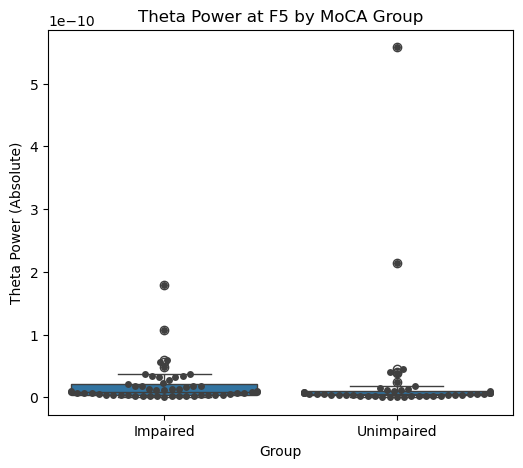

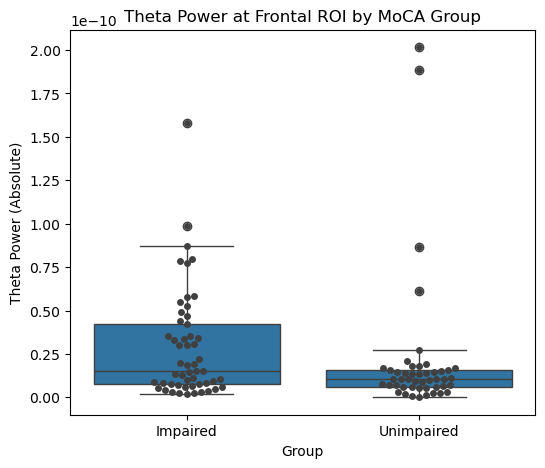

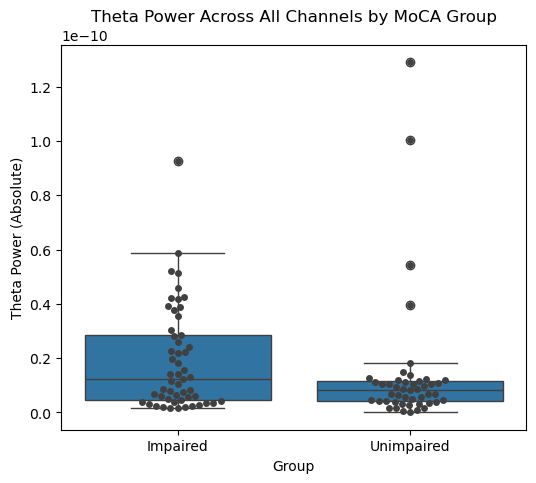

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load CSV
df = pd.read_csv("ML_Feature_Matrix.csv")

# Define features
theta_F5 = df['Feature_Theta_F5_Abs'].values
theta_frontal = df['Feature_Theta_Frontal_ROI_Abs'].values
theta_global = df['Feature_Theta_Global_Abs'].values

# MoCA impaired labels
group_labels = df['Label_Impaired'].map({1: 'Impaired', 0: 'Unimpaired'}).values

# Function to plot box + swarm
def plot_theta(theta_array, group_labels, title):
    df_plot = pd.DataFrame({
        'Theta_Power': theta_array,
        'Group': group_labels
    })
    plt.figure(figsize=(6,5))
    sns.boxplot(x='Group', y='Theta_Power', data=df_plot)
    sns.swarmplot(x='Group', y='Theta_Power', data=df_plot, color=".25")
    plt.title(title)
    plt.ylabel('Theta Power (Absolute)')
    plt.show()

# Plot F5
plot_theta(theta_F5, group_labels, 'Theta Power at F5 by MoCA Group')

# Plot Frontal ROI
plot_theta(theta_frontal, group_labels, 'Theta Power at Frontal ROI by MoCA Group')

# Plot Global
plot_theta(theta_global, group_labels, 'Theta Power Across All Channels by MoCA Group')

'''import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load CSV
df = pd.read_csv("ML_Feature_Matrix.csv")

# Define features
theta_F5 = df['Feature_Theta_F5_Abs'].values
theta_frontal = df['Feature_Theta_Frontal_ROI_Abs'].values
theta_global = df['Feature_Theta_Global_Abs'].values

# MoCA impaired labels
group_labels = df['Label_Impaired'].map({1: 'Impaired', 0: 'Unimpaired'}).values

# Function to plot box + swarm with optional y-limits
def plot_theta(theta_array, group_labels, title, y_lim=None):
    df_plot = pd.DataFrame({
        'Theta_Power': theta_array,
        'Group': group_labels
    })
    plt.figure(figsize=(6,5))
    sns.boxplot(x='Group', y='Theta_Power', data=df_plot)
    sns.swarmplot(x='Group', y='Theta_Power', data=df_plot, color=".25")
    if y_lim is not None:
        plt.ylim(y_lim)
    plt.title(title)
    plt.ylabel('Theta Power (Absolute)')
    plt.show()

# Plot F5 with y-axis limit to focus on main range
plot_theta(theta_F5, group_labels, 'Theta Power at F5 by MoCA Group', y_lim=(0, 3e-11))

# Plot Frontal ROI (optional y-limit)
plot_theta(theta_frontal, group_labels, 'Theta Power at Frontal ROI by MoCA Group', y_lim=(0, 3e-11))

# Plot Global (optional y-limit)
plot_theta(theta_global, group_labels, 'Theta Power Across All Channels by MoCA Group', y_lim=(0, 3e-11))
'''


### Theta-alpha (7–13 Hz) oscillation frequency

In [ ]:
import os
import numpy as np
import pandas as pd
import mne
from mne.time_frequency import psd_array_welch

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
SUBJECTS = [f"sub-{i:03d}" for i in range(1, 150)]  # adjust range as needed
THETA_ALPHA_BAND = (7, 13)
FMIN, FMAX = 1, 45
N_FFT = 512

results = []

for SUBJ in SUBJECTS:
    EPO_FILE = os.path.join(BASE_DIR, SUBJ, f"epo_{SUBJ[-3:]}_raw.fif")
    if not os.path.exists(EPO_FILE):
        print(f"{SUBJ}: missing epoch file")
        continue

    try:
        epochs = mne.read_epochs(EPO_FILE, preload=True, verbose=False)
    except Exception as e:
        print(f"{SUBJ}: failed to read epochs ({e})")
        continue

    sfreq = epochs.info.get("sfreq", None)
    if sfreq is None or sfreq <= 0:
        print(f"{SUBJ}: invalid sampling rate, skipping")
        continue

    ch_names = epochs.ch_names
    data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)

    # Compute PSD (Welch)
    n_per_seg = int(sfreq * 4)  # 4s windows (adjust if needed)
    psds, freqs = psd_array_welch(
        data, sfreq=sfreq, fmin=FMIN, fmax=FMAX,
        n_fft=N_FFT, n_per_seg=n_per_seg, window='hann', average='mean'
    )
    # psds shape: (n_epochs, n_channels, n_freqs)
    freq_res = freqs[1] - freqs[0]

    # Save per-subject PSD CSV (channels x freq columns) averaged over epochs
    DATA_DIR = os.path.join(BASE_DIR, SUBJ, "data")
    os.makedirs(DATA_DIR, exist_ok=True)
    psd_mean_across_epochs = psds.mean(axis=0)  # shape: (n_channels, n_freqs)

    # Build DataFrame: one row per channel, columns: 'channel', '1.00', '1.25', ...
    freq_col_names = [f"{f:.2f}" for f in freqs]
    rows = []
    for c_idx, ch in enumerate(ch_names):
        row = {'channel': ch}
        # use zipped assignment for speed
        for f_idx, fname in enumerate(freq_col_names):
            row[fname] = psd_mean_across_epochs[c_idx, f_idx]
        rows.append(row)
    df_psd = pd.DataFrame(rows)
    psd_csv_path = os.path.join(DATA_DIR, f"{SUBJ}_psd_epoch.csv")
    df_psd.to_csv(psd_csv_path, index=False)
    print(f"{SUBJ}: saved PSD CSV -> {psd_csv_path}")

    # Compute theta-alpha (7–13 Hz) peak:
    band_idx = np.logical_and(freqs >= THETA_ALPHA_BAND[0], freqs <= THETA_ALPHA_BAND[1])
    if not band_idx.any():
        print(f"{SUBJ}: no frequencies found in {THETA_ALPHA_BAND}, skipping peak computation")
        continue

    # Option A: average PSD across epochs and channels then find the peak (matching   earlier version)
    band_psd = psds[:, :, band_idx]  # (epochs, channels, freqs_in_band)
    mean_band_psd = band_psd.mean(axis=(0, 1))  # average across epochs & channels -> (freqs_in_band,)
    peak_idx = np.argmax(mean_band_psd)
    peak_freq = freqs[band_idx][peak_idx]

    # Append subject result
    results.append({'participant_id': SUBJ, 'theta_alpha_peak_freq': float(peak_freq)})

# Save global summary CSV
df_peaks = pd.DataFrame(results)
summary_path = os.path.join(BASE_DIR, "theta_alpha_peak_freq.csv")
df_peaks.to_csv(summary_path, index=False)
print("Theta–alpha peak frequency computation complete.")
print(f"Summary saved to: {summary_path}")


In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, spearmanr

# Load data
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
df_freq = pd.read_csv(f"{BASE_DIR}\\theta_alpha_peak_freq.csv")
meta = pd.read_csv("participants.csv")

# Merge with metadata
df = df_freq.merge(
    meta[['participant_id', 'GROUP', 'MOCA']],
    on='participant_id',
    how='inner'
)

# PD only
df = df[df['GROUP'] == 'PD']
df = df.dropna(subset=['theta_alpha_peak_freq', 'MOCA'])

# Labels
df['impaired'] = df['MOCA'] < 26

impaired = df.loc[df['impaired'], 'theta_alpha_peak_freq'].values
unimpaired = df.loc[~df['impaired'], 'theta_alpha_peak_freq'].values

# Group comparison
t, p = ttest_ind(impaired, unimpaired, equal_var=False)

# Continuous association
rho, p_corr = spearmanr(df['theta_alpha_peak_freq'], df['MOCA'])

print(f"Theta–alpha peak frequency | PD only: N={len(df)}")
print(f"Impaired (MoCA<26): {len(impaired)}, Unimpaired (MoCA>=26): {len(unimpaired)}")
print(f"Impaired mean={impaired.mean():.4f}, std={impaired.std():.4f}")
print(f"Unimpaired mean={unimpaired.mean():.4f}, std={unimpaired.std():.4f}")
print(f"t={t:.3f}, p={p:.6g}")
print(f"Spearman rho={rho:.3f}, p={p_corr:.6g}")


Theta–alpha peak frequency | PD only: N=100
Impaired (MoCA<26): 53, Unimpaired (MoCA>=26): 47
Impaired mean=8.4390, std=1.3953
Unimpaired mean=8.8722, std=1.2308
t=-1.633, p=0.105671
Spearman rho=0.244, p=0.0143712


### Beta oscillation amplitude (13–25 Hz) NOT SIG

In [10]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, spearmanr

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"

meta = pd.read_csv("participants.csv")
PD_SUBS = meta.loc[meta['GROUP'] == 'PD', 'participant_id'].tolist()

beta_vals = []
moca_vals = []

for subj in PD_SUBS:
    csv_file = os.path.join(BASE_DIR, subj, "data", f"{subj}_bandpowers_epoch.csv")
    if not os.path.exists(csv_file):
        print(f"{subj}: missing bandpower CSV")
        continue

    df = pd.read_csv(csv_file)

    if "beta_abs" not in df.columns:
        print(f"{subj}: beta_abs missing")
        continue

    # Average beta power across epochs and channels
    beta_mean = df["beta_abs"].mean()
    beta_vals.append(beta_mean)

    moca = meta.loc[meta['participant_id'] == subj, 'MOCA'].values
    if len(moca) == 0 or np.isnan(moca[0]):
        continue
    moca_vals.append(moca[0])

beta_vals = np.array(beta_vals)
moca_vals = np.array(moca_vals)

labels = (moca_vals < 26).astype(int)
impaired = beta_vals[labels == 1]
unimpaired = beta_vals[labels == 0]

t, p = ttest_ind(impaired, unimpaired, equal_var=False)
rho, p_corr = spearmanr(beta_vals, moca_vals)

print(f"Beta amplitude (13–30 Hz) | PD only: N={len(beta_vals)}")
print(f"Impaired (MoCA<26): {len(impaired)}, Unimpaired (MoCA>=26): {len(unimpaired)}")
print(f"Impaired mean={impaired.mean():.6g}, std={impaired.std():.6g}")
print(f"Unimpaired mean={unimpaired.mean():.6g}, std={unimpaired.std():.6g}")
print(f"t={t:.3f}, p={p:.6g}, Spearman rho={rho:.3f}, p={p_corr:.6g}")


Beta amplitude (13–30 Hz) | PD only: N=100
Impaired (MoCA<26): 53, Unimpaired (MoCA>=26): 47
Impaired mean=9.57684e-12, std=5.29329e-12
Unimpaired mean=9.90786e-12, std=7.18806e-12
t=-0.257, p=0.797992, Spearman rho=-0.029, p=0.774656


### Gamma Power Posterior-Parietal Occipital region

In [13]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, spearmanr

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
GAMMA_CH = ['P3','P4','Oz','O2','O1','POz','PO7','PO8']

meta = pd.read_csv(r"C:\Users\User\Documents\EEG_Project\rEEG\participants.csv")
PD_SUBS = meta.loc[meta['GROUP'] == 'PD', 'participant_id'].tolist()

gamma_data = []
moca_vals_list = []

for subj in PD_SUBS:
    csv_file = os.path.join(BASE_DIR, subj, "data", f"{subj}_bandpowers_epoch.csv")
    if not os.path.exists(csv_file):
        print(f"{subj}: missing CSV")
        continue

    df = pd.read_csv(csv_file)
    df['channel_clean'] = df['channel'].str.strip().str.upper()
    gamma_upper = [ch.upper() for ch in GAMMA_CH]
    matched_chs = df.loc[df['channel_clean'].isin(gamma_upper)]

    if matched_chs.empty:
        print(f"{subj}: no gamma channels matched in CSV")
        continue

    gamma_mean = matched_chs['high_beta_low_gamma_abs'].mean()
    gamma_data.append(gamma_mean)

    moca_vals = meta.loc[meta['participant_id'] == subj, 'MOCA'].values
    if len(moca_vals) == 0 or np.isnan(moca_vals[0]):
        continue
    moca_vals_list.append(moca_vals[0])

gamma_data = np.array(gamma_data)
moca_vals_list = np.array(moca_vals_list)

labels = (moca_vals_list < 26).astype(int)
impaired = gamma_data[labels == 1]
unimpaired = gamma_data[labels == 0]

t, p = ttest_ind(impaired, unimpaired, equal_var=False)
rho, p_corr = spearmanr(gamma_data, moca_vals_list)

print(f"High_beta_low_gamma_abs power averaged across selected channels | Cohort counts (PD only): {len(gamma_data)}")
print(f"Impaired (MoCA<26): {len(impaired)}, Unimpaired (MoCA>=26): {len(unimpaired)}")
print(f"Impaired mean={impaired.mean():.6g}, std={impaired.std():.6g}")
print(f"Unimpaired mean={unimpaired.mean():.6g}, std={unimpaired.std():.6g}")
print(f"t={t:.3f}, p={p:.6g}, Spearman rho={rho:.3f}, p={p_corr:.6g}")
print('NEW')

from statsmodels.stats.multitest import fdrcorrection

# collect p-values
p_vals = np.array([p, p_corr])

# Benjamini–Hochberg FDR
rej, p_fdr = fdrcorrection(p_vals, alpha=0.05, method='indep')

p_t_fdr, p_corr_fdr = p_fdr

print(f"t={t:.3f}, raw p={p:.6g}, FDR p={p_t_fdr:.6g}")
print(f"Spearman rho={rho:.3f}, raw p={p_corr:.6g}, FDR p={p_corr_fdr:.6g}")

High_beta_low_gamma_abs power averaged across selected channels | Cohort counts (PD only): 100
Impaired (MoCA<26): 53, Unimpaired (MoCA>=26): 47
Impaired mean=2.98467e-12, std=2.88282e-12
Unimpaired mean=1.74788e-12, std=1.65392e-12
t=2.641, p=0.00983919, Spearman rho=-0.258, p=0.00959718
NEW
t=2.641, raw p=0.00983919, FDR p=0.00983919
Spearman rho=-0.258, raw p=0.00959718, FDR p=0.00983919


In [16]:
# -------------------------------
# Recompute statistics on cleaned data for plotting
# -------------------------------
# Create DataFrame to ensure alignment
plot_df = pd.DataFrame({
    'Gamma_Power': gamma_data,
    'MoCA_Score': moca_vals_list
})

# Drop any rows with NaN just in case
plot_df = plot_df.dropna(subset=['Gamma_Power', 'MoCA_Score']).reset_index(drop=True)

# Define impairment labels
plot_df['Group'] = plot_df['MoCA_Score'].apply(lambda x: 'Impaired' if x < 26 else 'Unimpaired')

# Recompute t-test
labels = (plot_df['MoCA_Score'] < 26).astype(int)
impaired = plot_df.loc[labels == 1, 'Gamma_Power']
unimpaired = plot_df.loc[labels == 0, 'Gamma_Power']

t, p = ttest_ind(impaired, unimpaired, equal_var=False)

# Recompute Spearman correlation
rho, p_corr = spearmanr(plot_df['Gamma_Power'], plot_df['MoCA_Score'])

# Apply FDR correction again
from statsmodels.stats.multitest import fdrcorrection

p_vals = np.array([p, p_corr])
rej, p_fdr = fdrcorrection(p_vals, alpha=0.05, method='indep')
p_t_fdr, p_corr_fdr = p_fdr

# Print aligned statistics
print("Recomputed statistics aligned with plot_df:")
print(f"t={t:.3f}, raw p={p:.6g}, FDR p={p_t_fdr:.6g}")
print(f"Spearman rho={rho:.3f}, raw p={p_corr:.6g}, FDR p={p_corr_fdr:.6g}")

Recomputed statistics aligned with plot_df:
t=2.641, raw p=0.00983919, FDR p=0.00983919
Spearman rho=-0.258, raw p=0.00959718, FDR p=0.00983919


In [8]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, spearmanr

BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
GAMMA_CH = ['P3','P4','Oz','O2','O1','POz','PO7','PO8']

meta = pd.read_csv(r"C:\Users\User\Documents\EEG_Project\rEEG\participants.csv")

# Get PD and HC participant IDs
PD_SUBS = meta.loc[meta['GROUP'] == 'PD', 'participant_id'].tolist()
HC_SUBS = meta.loc[meta['GROUP'] == 'Control', 'participant_id'].tolist()

def load_gamma(sub_list):
    gamma_data = []
    moca_vals_list = []
    for subj in sub_list:
        csv_file = os.path.join(BASE_DIR, subj, "data", f"{subj}_bandpowers_epoch.csv")
        if not os.path.exists(csv_file):
            print(f"{subj}: missing CSV")
            continue

        df = pd.read_csv(csv_file)
        df['channel_clean'] = df['channel'].str.strip().str.upper()
        gamma_upper = [ch.upper() for ch in GAMMA_CH]
        matched_chs = df.loc[df['channel_clean'].isin(gamma_upper)]

        if matched_chs.empty:
            print(f"{subj}: no gamma channels matched in CSV")
            continue

        gamma_mean = matched_chs['high_beta_low_gamma_abs'].mean()
        gamma_data.append(gamma_mean)

        # Optionally get MoCA for correlation
        moca_vals = meta.loc[meta['participant_id'] == subj, 'MOCA'].values
        if len(moca_vals) > 0 and not np.isnan(moca_vals[0]):
            moca_vals_list.append(moca_vals[0])
        else:
            moca_vals_list.append(np.nan)

    return np.array(gamma_data), np.array(moca_vals_list)

# Load data for both groups
gamma_PD, moca_PD = load_gamma(PD_SUBS)
gamma_HC, moca_HC = load_gamma(HC_SUBS)

# Group comparison PD vs HC
t, p = ttest_ind(gamma_PD, gamma_HC, equal_var=False)

# Correlation across all participants (PD+HC)
all_gamma = np.concatenate([gamma_PD, gamma_HC])
all_moca = np.concatenate([moca_PD, moca_HC])
# Remove NaNs
valid_idx = ~np.isnan(all_moca)
rho, p_corr = spearmanr(all_gamma[valid_idx], all_moca[valid_idx])

print(f"High-beta/low-gamma absolute power averaged across selected channels | Cohort counts: PD={len(gamma_PD)}, HC={len(gamma_HC)}")
print(f"PD mean={gamma_PD.mean():.6g}, std={gamma_PD.std():.6g}")
print(f"HC mean={gamma_HC.mean():.6g}, std={gamma_HC.std():.6g}")
print(f"t={t:.3f}, p={p:.6g}, Spearman rho={rho:.3f}, p={p_corr:.6g}")


High-beta/low-gamma absolute power averaged across selected channels | Cohort counts: PD=100, HC=49
PD mean=2.40338e-12, std=2.46401e-12
HC mean=1.2994e-12, std=9.45615e-13
t=3.904, p=0.00014583, Spearman rho=-0.243, p=0.0028548


### Visulaization

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -------------------------------
# Prepare DataFrame for Plotting
# -------------------------------
plot_df = pd.DataFrame({
    'Gamma_Power': all_gamma,
    'MoCA_Score': all_moca
})

# Drop NaNs (important for plotting + stats consistency)
plot_df = plot_df.dropna(subset=['MoCA_Score'])

# Define impairment groups by MoCA
plot_df['Group'] = plot_df['MoCA_Score'].apply(
    lambda x: 'Impaired' if x < 26 else 'Unimpaired'
)

# Explicit color mapping
palette = {
    'Impaired': 'red',
    'Unimpaired': 'blue'
}

# -------------------------------
# Visualization Settings
# -------------------------------
sns.set_context("talk")
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# -------------------------------
# Left Plot: Group Comparison
# -------------------------------
sns.boxplot(
    x='Group',
    y='Gamma_Power',
    data=plot_df,
    order=['Unimpaired', 'Impaired'],
    palette=palette,
    ax=ax[0]
)

sns.stripplot(
    x='Group',
    y='Gamma_Power',
    data=plot_df,
    order=['Unimpaired', 'Impaired'],
    palette=palette,
    alpha=0.5,
    ax=ax[0]
)

ax[0].set_title(f'Posterior High Beta / Low Gamma\n(t={t:.2f}, p={p:.4f})')
ax[0].set_ylabel('Mean Absolute Power (30–45 Hz)')
ax[0].set_xlabel('')

# -------------------------------
# Right Plot: MoCA Correlation
# -------------------------------
sns.scatterplot(
    x='MoCA_Score',
    y='Gamma_Power',
    hue='Group',
    data=plot_df,
    palette=palette,
    s=80,
    alpha=0.7,
    ax=ax[1]
)

# Linear fit
sns.regplot(
    x='MoCA_Score',
    y='Gamma_Power',
    data=plot_df,
    scatter=False,
    line_kws={'color': 'black', 'label': 'Linear Fit'},
    ax=ax[1]
)

# LOWESS (nonlinear) trend
sns.regplot(
    x='MoCA_Score',
    y='Gamma_Power',
    data=plot_df,
    lowess=True,
    scatter=False,
    line_kws={'color': 'gray', 'linestyle': '--', 'label': 'Non-linear Trend'},
    ax=ax[1]
)

# MoCA impairment threshold
ax[1].axvline(26, color='black', linestyle=':', label='Impairment Threshold')

ax[1].set_title(
    f'Correlation with Cognitive Score\n'
    f'(Spearman $\\rho$={rho:.3f}, p={p_corr:.4g})'
)
ax[1].set_xlabel('MoCA Score')
ax[1].set_ylabel('Mean Absolute Power (30–45 Hz)')
ax[1].legend()

plt.tight_layout()
plt.savefig('gamma_diagnostic_plot.png', dpi=300)
plt.show()


NameError: name 'all_gamma' is not defined

C:\Users\User\AppData\Local\Temp\ipykernel_31012\3792077703.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\User\AppData\Local\Temp\ipykernel_31012\3792077703.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


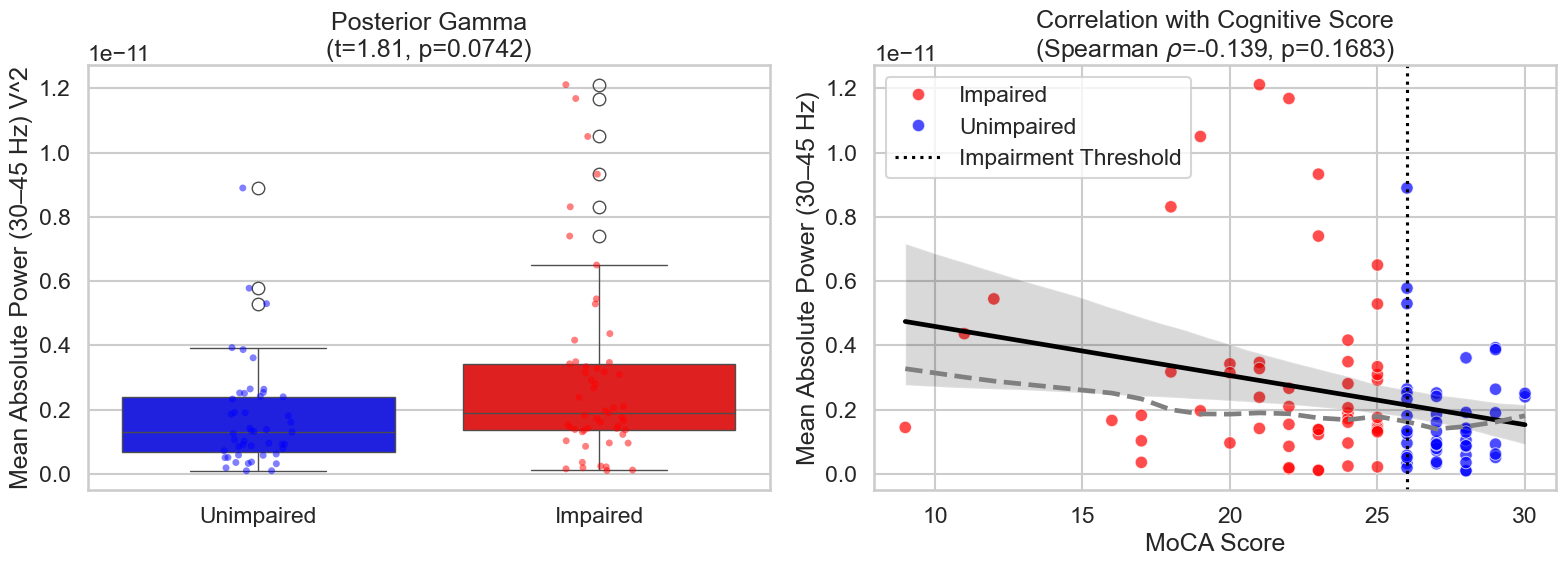

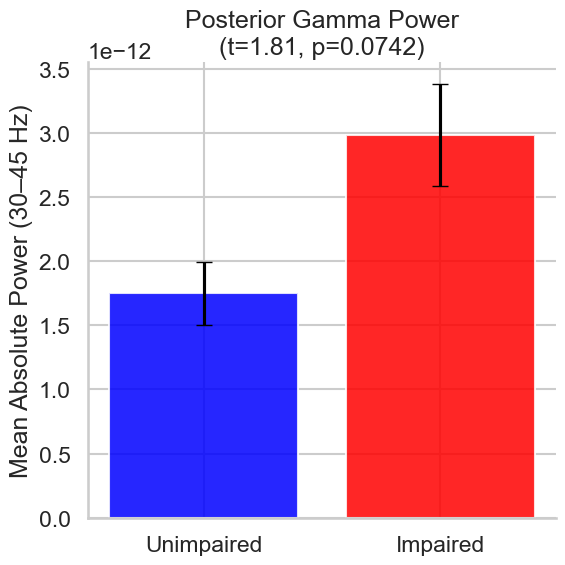

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# -------------------------------
# Prepare DataFrame for Plotting
# -------------------------------
# Use the variables from the first code block
plot_df = pd.DataFrame({
    'Gamma_Power': gamma_data,
    'MoCA_Score': moca_vals_list
})

# Drop NaNs (important for plotting + stats consistency)
plot_df = plot_df.dropna(subset=['MoCA_Score'])

# Define impairment groups by MoCA
plot_df['Group'] = plot_df['MoCA_Score'].apply(
    lambda x: 'Impaired' if x < 26 else 'Unimpaired'
)

# Explicit color mapping
palette = {
    'Impaired': 'red',
    'Unimpaired': 'blue'
}

# -------------------------------
# Visualization Settings
# -------------------------------
sns.set_context("talk")
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# -------------------------------
# Left Plot: Group Comparison
# -------------------------------
sns.boxplot(
    x='Group',
    y='Gamma_Power',
    data=plot_df,
    order=['Unimpaired', 'Impaired'],
    palette=palette,
    ax=ax[0]
)

sns.stripplot(
    x='Group',
    y='Gamma_Power',
    data=plot_df,
    order=['Unimpaired', 'Impaired'],
    palette=palette,
    alpha=0.5,
    ax=ax[0]
)

ax[0].set_title(f'Posterior Gamma\n(t={t:.2f}, p={p:.4f})')
ax[0].set_ylabel('Mean Absolute Power (30–45 Hz) V^2')
ax[0].set_xlabel('')

# -------------------------------
# Right Plot: MoCA Correlation
# -------------------------------
sns.scatterplot(
    x='MoCA_Score',
    y='Gamma_Power',
    hue='Group',
    data=plot_df,
    palette=palette,
    s=80,
    alpha=0.7,
    ax=ax[1]
)

# Linear fit
sns.regplot(
    x='MoCA_Score',
    y='Gamma_Power',
    data=plot_df,
    scatter=False,
    line_kws={'color': 'black', 'label': 'Linear Fit'},
    ax=ax[1]
)

# LOWESS (nonlinear) trend
sns.regplot(
    x='MoCA_Score',
    y='Gamma_Power',
    data=plot_df,
    lowess=True,
    scatter=False,
    line_kws={'color': 'gray', 'linestyle': '--', 'label': 'Non-linear Trend'},
    ax=ax[1]
)

# MoCA impairment threshold
ax[1].axvline(26, color='black', linestyle=':', label='Impairment Threshold')

ax[1].set_title(
    f'Correlation with Cognitive Score\n'
    f'(Spearman $\\rho$={rho:.3f}, p={p_corr:.4g})'
)
ax[1].set_xlabel('MoCA Score')
ax[1].set_ylabel('Mean Absolute Power (30–45 Hz)')
ax[1].legend()

plt.tight_layout()
plt.savefig('gamma_diagnostic_plot.png', dpi=300)
plt.show()

# -------------------------------
# Bar Plot with Error Bars
# -------------------------------
# Aggregate statistics
group_stats = (
    plot_df
    .groupby('Group')['Gamma_Power']
    .agg(['mean', 'sem'])
    .reindex(['Unimpaired', 'Impaired'])
)

# Plot
plt.figure(figsize=(6, 6))

plt.bar(
    group_stats.index,
    group_stats['mean'],
    yerr=group_stats['sem'],
    capsize=6,
    color=[palette[g] for g in group_stats.index],
    alpha=0.85
)

plt.ylabel('Mean Absolute Power (30–45 Hz)')
plt.title(
    f'Posterior Gamma Power\n'
    f'(t={t:.2f}, p={p:.4f})'
)

sns.despine()
plt.tight_layout()
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_31012\2624566767.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\User\AppData\Local\Temp\ipykernel_31012\2624566767.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


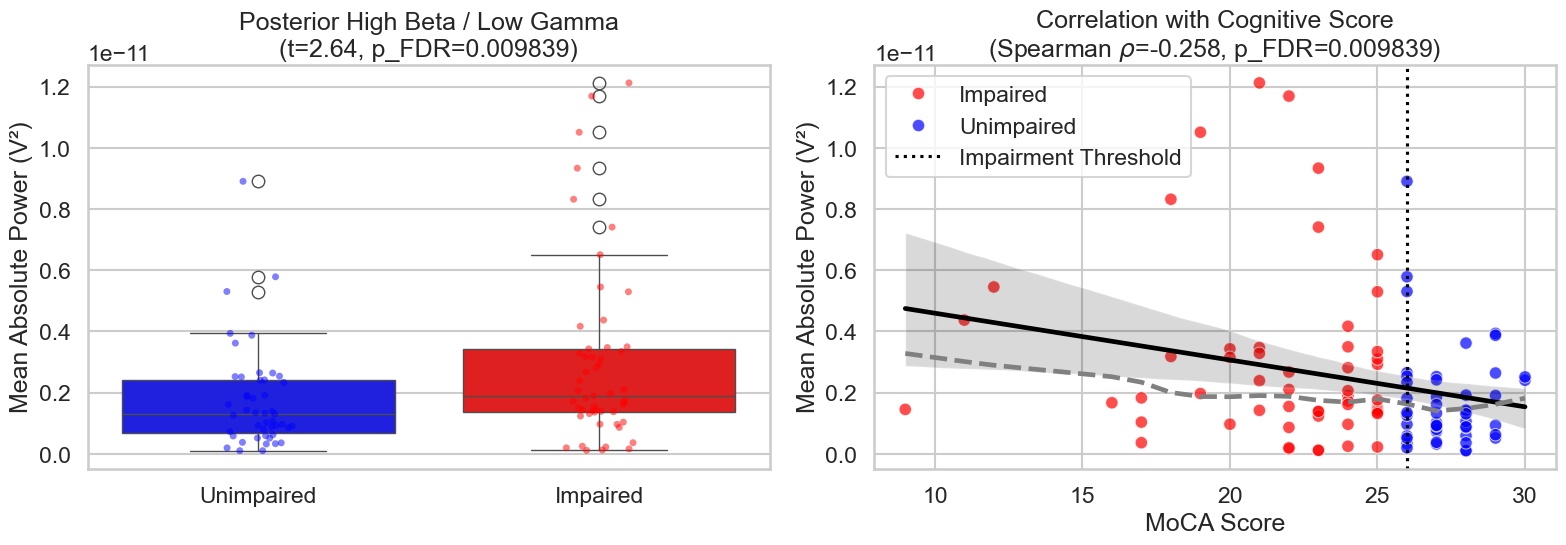

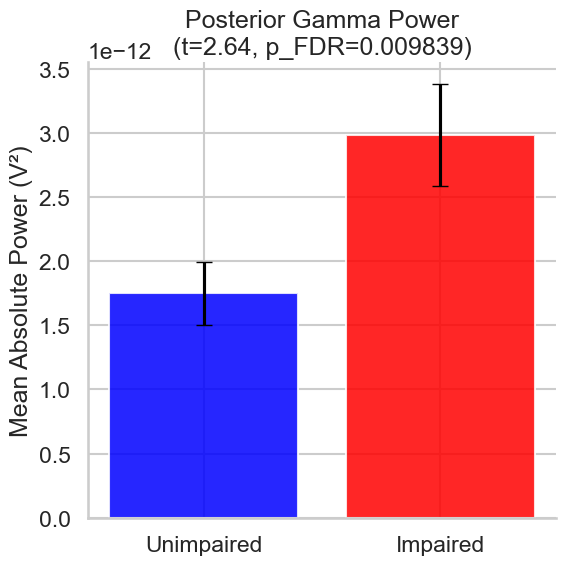

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# -------------------------------
# Prepare DataFrame for Plotting
# -------------------------------
# Use gamma_data, moca_vals_list from previous code
plot_df = pd.DataFrame({
    'Gamma_Power': gamma_data,
    'MoCA_Score': moca_vals_list
})

# Drop NaNs (just in case)
plot_df = plot_df.dropna(subset=['Gamma_Power', 'MoCA_Score']).reset_index(drop=True)

# Define impairment groups by MoCA
plot_df['Group'] = plot_df['MoCA_Score'].apply(lambda x: 'Impaired' if x < 26 else 'Unimpaired')

# Explicit color mapping
palette = {'Impaired': 'red', 'Unimpaired': 'blue'}

# -------------------------------
# Visualization Settings
# -------------------------------
sns.set_context("talk")
sns.set_style("whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# -------------------------------
# Left Plot: Group Comparison
# -------------------------------
sns.boxplot(
    x='Group',
    y='Gamma_Power',
    data=plot_df,
    order=['Unimpaired', 'Impaired'],
    palette=palette,
    ax=ax[0]
)

sns.stripplot(
    x='Group',
    y='Gamma_Power',
    data=plot_df,
    order=['Unimpaired', 'Impaired'],
    palette=palette,
    alpha=0.5,
    ax=ax[0]
)

ax[0].set_title(f'Posterior High Beta / Low Gamma\n(t={t:.2f}, p_FDR={p_t_fdr:.4g})')
ax[0].set_ylabel('Mean Absolute Power (V²)')
ax[0].set_xlabel('')

# -------------------------------
# Right Plot: MoCA Correlation
# -------------------------------
sns.scatterplot(
    x='MoCA_Score',
    y='Gamma_Power',
    hue='Group',
    data=plot_df,
    palette=palette,
    s=80,
    alpha=0.7,
    ax=ax[1]
)

# Linear fit
sns.regplot(
    x='MoCA_Score',
    y='Gamma_Power',
    data=plot_df,
    scatter=False,
    line_kws={'color': 'black', 'label': 'Linear Fit'},
    ax=ax[1]
)

# LOWESS trend
sns.regplot(
    x='MoCA_Score',
    y='Gamma_Power',
    data=plot_df,
    lowess=True,
    scatter=False,
    line_kws={'color': 'gray', 'linestyle': '--', 'label': 'Non-linear Trend'},
    ax=ax[1]
)

# MoCA impairment threshold
ax[1].axvline(26, color='black', linestyle=':', label='Impairment Threshold')

ax[1].set_title(
    f'Correlation with Cognitive Score\n(Spearman $\\rho$={rho:.3f}, p_FDR={p_corr_fdr:.4g})'
)
ax[1].set_xlabel('MoCA Score')
ax[1].set_ylabel('Mean Absolute Power (V²)')
ax[1].legend()

plt.tight_layout()
plt.savefig('gamma_diagnostic_plot.png', dpi=300)
plt.show()

# -------------------------------
# Bar Plot with Error Bars
# -------------------------------
# Aggregate statistics
group_stats = (
    plot_df
    .groupby('Group')['Gamma_Power']
    .agg(['mean', 'sem'])
    .reindex(['Unimpaired', 'Impaired'])
)

plt.figure(figsize=(6, 6))

plt.bar(
    group_stats.index,
    group_stats['mean'],
    yerr=group_stats['sem'],
    capsize=6,
    color=[palette[g] for g in group_stats.index],
    alpha=0.85
)

plt.ylabel('Mean Absolute Power (V²)')
plt.title(f'Posterior Gamma Power\n(t={t:.2f}, p_FDR={p_t_fdr:.4g})')

sns.despine()
plt.tight_layout()
plt.show()

In [6]:
import os
import numpy as np
import pandas as pd
from tensorpac import Pac
from scipy.stats import spearmanr, ttest_ind
import mne

# --- Config ---
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
THETA_CH = ['F3', 'F4', 'Fz', 'F5', 'F1', 'F2', 'AF3', 'AF4', 'AFz']  # frontal theta
GAMMA_CH = ['P3','P4','Oz','O2','O1','POz','PO7','PO8']

meta = pd.read_csv("participants.csv")
PD_SUBS = meta.loc[meta['GROUP'] == 'PD', 'participant_id'].tolist()

# PAC object
p = Pac(idpac=(6, 0, 0), f_pha=(4, 8, 1, 0.2), f_amp=(30, 45, 2, 1))

# --- Store results ---
pac_vals_list = []
moca_vals_list = []

for subj in PD_SUBS:
    raw_file = os.path.join(BASE_DIR, subj, f"postICA{subj[-3:]}_raw.fif")  # corrected naming
    if not os.path.exists(raw_file):
        print(f"{subj}: missing raw file")
        continue
    
    raw = mne.io.read_raw_fif(raw_file, preload=True)
    sfreq = raw.info['sfreq']

    # Extract signals
    try:
        theta_signal = raw.copy().pick_channels(THETA_CH).get_data()[0]
    except:
        print(f"{subj}: missing theta channel")
        continue

    try:
        gamma_signal = raw.copy().pick_channels(GAMMA_CH).get_data().mean(axis=0)
    except:
        print(f"{subj}: missing gamma channels")
        continue

    # Filter signals
    phases = p.filter(sfreq, theta_signal, ftype='phase')
    amplitudes = p.filter(sfreq, gamma_signal, ftype='amplitude')

    # Fit PAC
    pac_matrix = p.fit(phases, amplitudes)
    pac_mean = pac_matrix.mean()

    # Store
    pac_vals_list.append(pac_mean)

    moca_vals = meta.loc[meta['participant_id'] == subj, 'MOCA'].values
    if len(moca_vals) == 0 or np.isnan(moca_vals[0]):
        continue
    moca_vals_list.append(moca_vals[0])

# Convert to arrays
pac_vals = np.array(pac_vals_list)
moca_vals_list = np.array(moca_vals_list)

# --- Split impaired vs unimpaired ---
labels = (moca_vals_list < 26).astype(int)
impaired = pac_vals[labels == 1]
unimpaired = pac_vals[labels == 0]

# --- Stats ---
t, p = ttest_ind(impaired, unimpaired, equal_var=False)
rho, p_corr = spearmanr(pac_vals, moca_vals_list)

# --- Output ---
print(f"Frontal theta → posterior gamma PAC | Cohort counts (PD only): {len(pac_vals)}")
print(f"Impaired (MoCA<26): {len(impaired)}, Unimpaired (MoCA>=26): {len(unimpaired)}")
print(f"Impaired mean={impaired.mean():.6g}, std={impaired.std():.6g}")
print(f"Unimpaired mean={unimpaired.mean():.6g}, std={unimpaired.std():.6g}")
print(f"t={t:.3f}, p={p:.6g}, Spearman rho={rho:.3f}, p={p_corr:.6g}")


FileNotFoundError: [Errno 2] No such file or directory: 'participants.csv'

### Frontal Delta/Theta connectivity

In [7]:
import os
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, spearmanr

# -------------------------------
# Config
# -------------------------------
BASE_DIR = r"C:\Users\User\Documents\EEG_Project\rEEG"
meta = pd.read_csv(os.path.join(BASE_DIR, "participants.csv"))
MOCA_COL = 'MOCA' if 'MOCA' in meta.columns else 'MoCA'
PD_SUBS = meta.loc[meta['GROUP']=='PD','participant_id'].tolist()

BAND = "alpha"  # frontal delta connectivity

# Frontal channels
FRONTAL_CH = ['FZ','F3','F4','F7','F8','FP1','FP2','FC1','FC2','AF7','AF3','AFZ','AF4','AF8']

# -------------------------------
# Helper
# -------------------------------
def upper_mean(mat):
    """Compute mean of upper triangle, excluding diagonal"""
    if mat.size == 0: 
        return np.nan
    iu = np.triu_indices_from(mat, k=1)
    return np.nanmean(mat[iu])

# -------------------------------
# Main
# -------------------------------
results = []

for subj in PD_SUBS:
    mat_path = os.path.join(BASE_DIR, subj, "data", f"{subj}_{BAND}_pli_matrix.npy")
    epo_path = os.path.join(BASE_DIR, subj, f"epo_{subj.split('-')[-1]}_raw.fif")
    
    if not os.path.exists(mat_path) or not os.path.exists(epo_path):
        print(f"{subj}: missing file(s), skipping")
        continue

    # Load matrix
    mat = np.load(mat_path)
    
    # Get channel indices
    import mne
    epochs = mne.read_epochs(epo_path, preload=False, verbose=False)
    chs = [c.upper() for c in epochs.ch_names]
    f_idx = [chs.index(c) for c in FRONTAL_CH if c in chs]
    if len(f_idx) < 2:
        print(f"{subj}: not enough frontal channels, skipping")
        continue

    # Ensure symmetry
    if not np.allclose(mat, mat.T):
        mat = (mat + mat.T)/2

    f_mean = upper_mean(mat[np.ix_(f_idx, f_idx)])

    moca_val = meta.loc[meta['participant_id']==subj, MOCA_COL].values[0]
    label = 1 if moca_val < 26 else 0

    results.append({
        'subject': subj,
        'frontal_delta_conn': f_mean,
        'MOCA': moca_val,
        'label': label
    })

# -------------------------------
# Stats
# -------------------------------
df = pd.DataFrame(results)
imp = df.loc[df['label']==1, 'frontal_delta_conn']
unimp = df.loc[df['label']==0, 'frontal_delta_conn']

t_stat, p_group = ttest_ind(imp, unimp, equal_var=False)
rho, p_corr = spearmanr(df['frontal_delta_conn'], df['MOCA'])

print(f"Frontal delta connectivity | PD only: N={len(df)}")
print(f"Impaired (MoCA<26): {len(imp)}, Unimpaired: {len(unimp)}")
print(f"Impaired mean={imp.mean():.6g}, std={imp.std():.6g}")
print(f"Unimpaired mean={unimp.mean():.6g}, std={unimp.std():.6g}")
print(f"t={t_stat:.3f}, p={p_group:.6g}")
print(f"Spearman rho={rho:.3f}, p={p_corr:.6g}")

# Optional: save results
# df.to_csv(os.path.join(BASE_DIR, "Frontal_Delta_Connectivity_PD.csv"), index=False)
# print("Results saved.")


C:\Users\User\AppData\Local\Temp\ipykernel_35564\419025074.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-001\epo_001_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_35564\419025074.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-002\epo_002_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_35564\419025074.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-003\epo_003_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epo

Frontal delta connectivity | PD only: N=100
Impaired (MoCA<26): 53, Unimpaired: 47
Impaired mean=0.0607181, std=0.0150806
Unimpaired mean=0.0630841, std=0.0179071
t=-0.710, p=0.479714
Spearman rho=0.086, p=0.395146


C:\Users\User\AppData\Local\Temp\ipykernel_35564\419025074.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-086\epo_086_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_35564\419025074.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-087\epo_087_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(epo_path, preload=False, verbose=False)
C:\Users\User\AppData\Local\Temp\ipykernel_35564\419025074.py:47: RuntimeWarning: This filename (C:\Users\User\Documents\EEG_Project\rEEG\sub-088\epo_088_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epo